# Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Load Data

In [22]:
movies_url = 'https://files.grouplens.org/datasets/movielens/ml-100k/u.item'

movie_columns = [
    'movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy',
    'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]
movies_df = pd.read_csv(movies_url, sep='|', encoding='latin-1', names=movie_columns, header=None)

print(movies_df.head())

   movie_id              title release_date  video_release_date  \
0         1   Toy Story (1995)  01-Jan-1995                 NaN   
1         2   GoldenEye (1995)  01-Jan-1995                 NaN   
2         3  Four Rooms (1995)  01-Jan-1995                 NaN   
3         4  Get Shorty (1995)  01-Jan-1995                 NaN   
4         5     Copycat (1995)  01-Jan-1995                 NaN   

                                            IMDb_URL  unknown  Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0       0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0       1   
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)        0       0   

   Adventure  Animation  Children's  ...  Fantasy  Film-Noir  Horror  Musical  \
0          0          1           1  ...        0          0       0        0

In [23]:
ratings_url = 'https://files.grouplens.org/datasets/movielens/ml-100k/u.data'

ratings_df = pd.read_csv(ratings_url, sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])
ratings_df = ratings_df.drop(columns=['timestamp'])

print(ratings_df.head())

   user_id  movie_id  rating
0      196       242       3
1      186       302       3
2       22       377       1
3      244        51       2
4      166       346       1


In [24]:
data = pd.merge(ratings_df, movies_df[['movie_id', 'title']], on='movie_id')

print("Merged Data:")
print(data.head())

Merged Data:
   user_id  movie_id  rating                       title
0      196       242       3                Kolya (1996)
1      186       302       3    L.A. Confidential (1997)
2       22       377       1         Heavyweights (1994)
3      244        51       2  Legends of the Fall (1994)
4      166       346       1         Jackie Brown (1997)


# EDA

In [25]:
num_users = data['user_id'].nunique()
num_movies = data['movie_id'].nunique()

print(f"Number of users: {num_users}, Number of movies: {num_movies}")

Number of users: 943, Number of movies: 1682


In [26]:
print("Rating distribution:")
print(data['rating'].value_counts().sort_index())

Rating distribution:
rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: count, dtype: int64


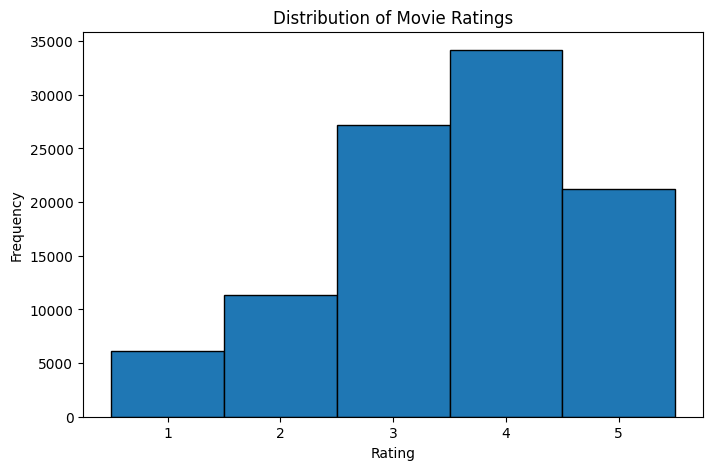

In [11]:
plt.figure(figsize=(8, 5))
plt.hist(data['rating'], bins=np.arange(0.5, 6, 1), edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Movie Ratings')
plt.show()

# Preprocessing

In [13]:
ratings_matrix = data.pivot(index='user_id', columns='movie_id', values='rating')
print("Utility Matrix shape (users x movies):", ratings_matrix.shape)

Utility Matrix shape (users x movies): (943, 1682)


In [14]:
ratings_matrix_filled = ratings_matrix.fillna(0)

In [28]:
user_similarity = cosine_similarity(ratings_matrix_filled)
user_similarity_df = pd.DataFrame(user_similarity, index=ratings_matrix.index, columns=ratings_matrix.index)

print("User Similarity Matrix:")
print(user_similarity_df.head())

User Similarity Matrix:
user_id       1         2         3         4         5         6         7    \
user_id                                                                         
1        1.000000  0.166931  0.047460  0.064358  0.378475  0.430239  0.440367   
2        0.166931  1.000000  0.110591  0.178121  0.072979  0.245843  0.107328   
3        0.047460  0.110591  1.000000  0.344151  0.021245  0.072415  0.066137   
4        0.064358  0.178121  0.344151  1.000000  0.031804  0.068044  0.091230   
5        0.378475  0.072979  0.021245  0.031804  1.000000  0.237286  0.373600   

user_id       8         9         10   ...       934       935       936  \
user_id                                ...                                 
1        0.319072  0.078138  0.376544  ...  0.369527  0.119482  0.274876   
2        0.103344  0.161048  0.159862  ...  0.156986  0.307942  0.358789   
3        0.083060  0.061040  0.065151  ...  0.031875  0.042753  0.163829   
4        0.188060  0.101284 

# Collaborative Filtering Recommendation System

In [ ]:
def predict_rating(user_id, movie_id, ratings_matrix, user_similarity_df):
    if movie_id in ratings_matrix.columns:
        sim_scores = user_similarity_df.loc[user_id]
        movie_ratings = ratings_matrix[movie_id]
        valid = movie_ratings.notna()
        sim_scores = sim_scores[valid]
        movie_ratings = movie_ratings[valid]
        if sim_scores.sum() == 0:
            return np.nan
        predicted = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
        return predicted

    else:
        return np.nan

In [ ]:
def recommend_movies(user_id, ratings_matrix, user_similarity_df, movies_df, n_recommendations=5):
    user_ratings = ratings_matrix.loc[user_id]
    unrated_movies = user_ratings[user_ratings.isna()].index

    predictions = {}
    for movie in unrated_movies:
        pred_rating = predict_rating(user_id, movie, ratings_matrix, user_similarity_df)
        predictions[movie] = pred_rating

    sorted_predictions = sorted(predictions.items(), key=lambda x: x[1] if x[1] is not None else 0, reverse=True)

    recommended = []
    for movie_id, pred in sorted_predictions[:n_recommendations]:
        title = movies_df[movies_df['movie_id'] == movie_id]['title'].values[0]
        recommended.append((movie_id, title, pred))

    return recommended

In [31]:
user_id_to_recommend = 1
recommended_movies = recommend_movies(user_id_to_recommend, ratings_matrix, user_similarity_df, movies_df, n_recommendations=5)

print(f"Top recommendations for user {user_id_to_recommend}:")
for movie_id, title, pred in recommended_movies:
    if pred is not None:
        print(f"Movie ID: {movie_id}, Title: {title}, Predicted Rating: {pred:.2f}")
    else:
        print(f"Movie ID: {movie_id}, Title: {title}, Predicted Rating: N/A")

Top recommendations for user 1:
Movie ID: 1189, Title: Prefontaine (1997), Predicted Rating: 5.00
Movie ID: 814, Title: Great Day in Harlem, A (1994), Predicted Rating: 5.00
Movie ID: 1122, Title: They Made Me a Criminal (1939), Predicted Rating: 5.00
Movie ID: 1201, Title: Marlene Dietrich: Shadow and Light (1996) , Predicted Rating: 5.00
Movie ID: 1467, Title: Saint of Fort Washington, The (1993), Predicted Rating: 5.00
